# Линейная регрессия.

Сегодня мы с вами перейдем к новому для нас разделу - **машинному обучению**. В целом машинное обучение - это наука, изучающая способы извлечения закономерностей из ограниченного количества примеров. Машинное обучение имеет множество применений и неразрывно связано с такими областями как искуственный интеллект и анализ данных. Нам же с вами будет интересная связь машинного обучения с анализом данных и статистикой.

Темой сегодняшнего семинара является **линейная регрессия**.

Сегодня на семинаре мы:

- познакомимся с определением одномерной и многомерной линейной регрессии
- поймем, как происходит оценка коэффициентов линейной регрессии
- научимся использовать библиотеку [Statsmodels](http://statsmodels.sourceforge.net/) для оценки коэффициентов
- поймем, как коэффициенты можно интерпретировать и как с их помощью строить прогнозы
- узнаем, как оценивать качество полученных прогнозов
- сделаем выводы из прогнозов
- поймем, что такое переобучение
- и даже поговорим про обработку категориальных признаков!!!

## Линейная регрессия

### Мотивация

Почему мы изучаем линейную регрессию?
- широко используема
- легко использовать (не нужно тюнить много параметров)
- относительно легко интерпретируема
- является базой для понимания более сложных алгоритмов
- встречается в независимом экзамене!!!


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Мы рассмотрим Advertising Dataset

В нём хранится информация об объемах продаж продукта и деньгах, потраченных на рекламу этого продукта на ТВ, радио и в газетах.


In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/hse-python-mirec/dap_mirec_2022/main/seminar9/Advertising.csv', index_col=0)
data.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


С точки зрения машинного обучения переменная *Sales* - будет являться **таргетом** (или зависимой переменной / целевой переменной), то есть тем, что мы хотим предсказать или на что хотим оценить влияние других переменных. А переменные *TV*, *Radio*, *Newspaper* будут являться **признаками** (регрессорами, фичами, факторами), то есть тем, с помощью чего мы можем описать нашу целевую переменную или посмотреть влияние признаков на неё.

В нашем случае есть следующие признаки:
- TV: доллары, потраченные на ТВ рекламу для одного продукта на данном рынке (в тысячах долларов)
- Radio: доллары, потраченные на радио рекламу
- Newspaper: доллары, потраченные на рекламу в газетах

И целевая переменная:
- Sales: продажи одного продукта на данном рынке (в тысячах)

In [4]:
data.shape

(200, 4)

В нашей выборке мы имеем 200 **наблюдений / "семплов"** (200 рынков в наборе данных)

Можем посмотреть на взаимосвязь между признаками и целевой переменной используя диаграмму рассеяния.

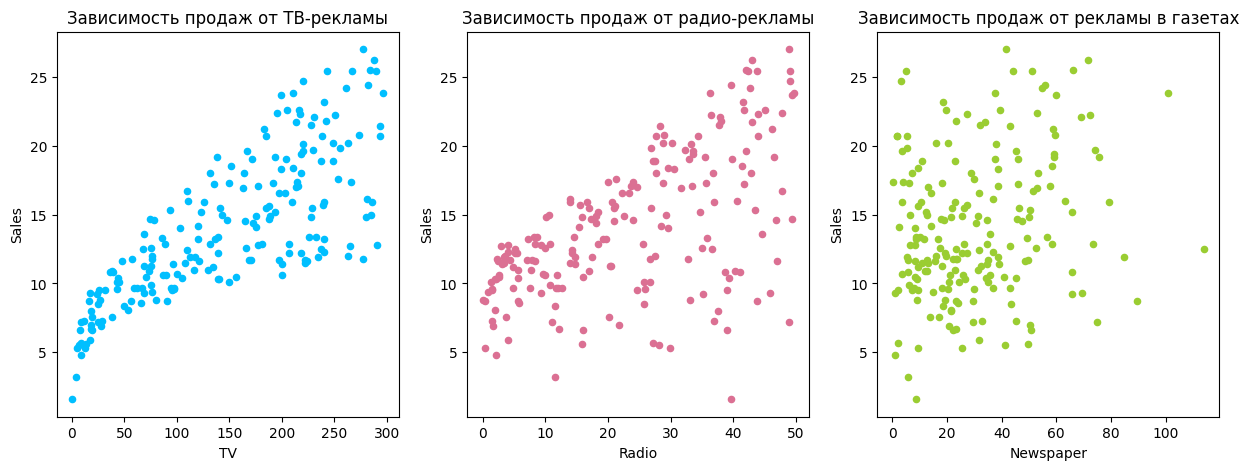

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
ax1 = data.plot(kind='scatter', x='TV', y='Sales', ax=axs[0], c='deepskyblue') # можете попробовать поменять цвета :)
ax2 = data.plot(kind='scatter', x='Radio', y='Sales', ax=axs[1], c='palevioletred')
ax3 = data.plot(kind='scatter', x='Newspaper', y='Sales', ax=axs[2], c='yellowgreen')
ax1.title.set_text('Зависимость продаж от ТВ-рекламы')
ax2.title.set_text('Зависимость продаж от радио-рекламы')
ax3.title.set_text('Зависимость продаж от рекламы в газетах')
plt.show()

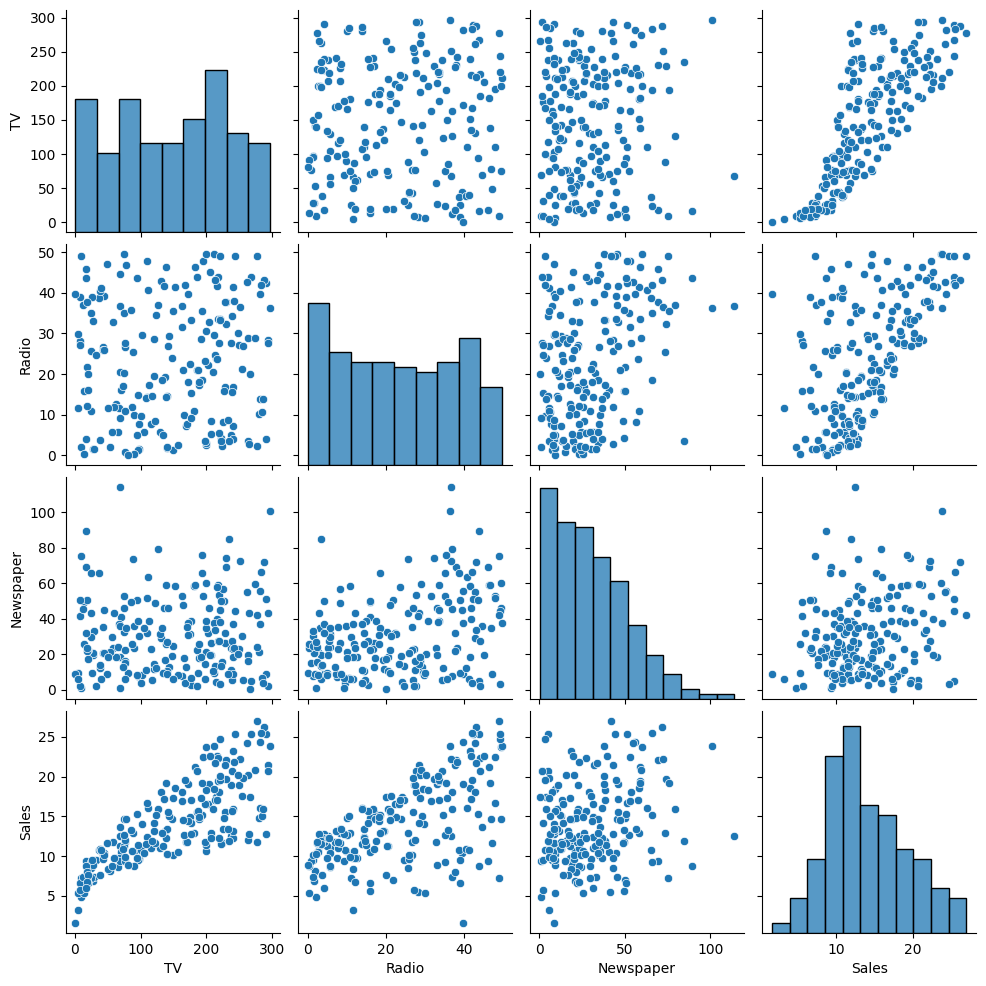

In [6]:
import seaborn as sns
sns.pairplot(data)

А теперь давайте представим, что вы работаете на компанию, которая производит и продает этот товар. Компания может задать вам следующий вопрос: на основании этих данных, как мы должны тратить наши рекламные деньги в будущем?

Этот общий вопрос может привести вас к более конкретным вопросам:
1. Существует ли связь между рекламой и продажами?
2. Насколько сильны эти отношения?
3. Какие типы рекламы способствуют росту продаж?
4. Зная расходы на рекламу на конкретном рынке, можем ли мы предсказать продажи?


Попробуем разобраться, как на эти вопросы ответить

## Одномерная линейная регрессия

Простая линейная регрессия - это подход к прогнозированию **количественной переменной** с использованием **одного признака**:

$y = \beta_0 + \beta_1x$

- $y$ это таргет
- $x$ это признак
- $\beta_0$ это свободный член
- $\beta_1$ это коэффициент при признаке x

То есть по сути если представить наши данные на диаграмме рассеяния, мы хотим провести через них прямую, наиболее хорошо отображающую данные.

Вместе $\beta_0$ и $\beta_1$ называются **коэффициентами модели**. Чтобы создать свою модель, вы должны "выучить" значения этих коэффициентов. И как только мы "выучим" эти коэффициенты, мы сможем использовать модель для прогнозирования продаж!

## Оценка («обучение») коэффициентов модели


В статистической модели машинного обучения коэффициенты оцениваются с использованием **метода наименьших квадратов**, что означает, что мы находим линию (математически), которая минимизирует **сумму квадратов остатков** (или «сумму квадратов ошибок»)




<img src="https://github.com/hse-python-mirec/dap_mirec_2022/blob/main/seminar9/images/08_estimating_coefficients.png?raw=true">

Что изображено на схеме?
- Черные точки - это **наблюдаемые значения** x и y.
- Синяя линия - это наша **линия полученная при минимизации квадратов ошибок**.
- Красные линии - это **остатки**, которые представляют собой расстояния между наблюдаемыми значениями и линией наименьших квадратов.

Как коэффициенты модели соотносятся с линией наименьших квадратов?
- $ \beta_0 $ - это **точка пересечения** (значение $ y $, когда $ x $ = 0)
- $ \beta_1 $ - это **наклон** (изменение $ y $, деленное на изменение $ x $)

Вот графическое изображение этих вычислений:

<img src="https://github.com/hse-python-mirec/dap_mirec_2022/blob/main/seminar9/images/08_slope_intercept.png?raw=true">

Давайте попробуем использовать библиотеку **Statsmodels** для оценки коэффициентов модели на наших данных

In [7]:
import statsmodels.formula.api as smf

# создаём модель по заданной формуле и обучаем ее на data при помощи метода .fit()
lm = smf.ols(formula='Sales ~ TV', data=data).fit()

# выведем полученные коэффициенты модели
lm.params

Intercept    7.032594
TV           0.047537
dtype: float64

В аргументе *formula* прописывается непосредственно формула, по которой мы хотим разложить наши данные. В текущем примере мы хотим составить следующую формулу: $Sales = \beta_0 + \beta_1 TV$, поэтому наша формула в statsmodels будет выглядеть как: $Sales \sim TV$.

Подробнее про составленее формул можно почитать [тут](https://patsy.readthedocs.io/en/latest/formulas.html).

Отлично, числа мы какие-то получили, но что с ними дальше делать? Давайте подумаем, как мы их можем проинтерпретировать.

## Интерпретация коэффициентов модели

Как мы интерпретируем TV коэффициент ($\beta_1$)?
- Дополнительные 1000 долларов, потраченные на телевизионную рекламу, увеличивают продажы на 47.537 товаров.

Обратите внимание, что если бы увеличение расходов на телевизионную рекламу было связано с **снижением** продаж, $\beta_1$ был бы **отрицательным**.

## Использование модели для прогнозирования

Как уже упоминалось выше, оценка влияния признаков на целевую переменную - это не единственное, что мы хотим делать.

Допустим, появился новый рынок, на котором расходы на телевизионную рекламу составили **$50.000**. Что бы мы спрогнозировали для продаж на этом рынке?

Так как мы уже знаем коэффициенты $\beta_0$ и $\beta_1$ остается только подставить все числа в формулу.

$$y = \beta_0 + \beta_1 TV$$
$$y = 7.032594 + 0.047537 \times 50$$

In [10]:
y = 7.032594 + 0.047537 * 50
y

9.409444

Таким образом, мы могли бы предсказать продажи **9409 товаров** на этом рынке.

Конечно, мы можем использовать Statsmodels и для прогнозирования:

In [13]:
# нам придется создать DataFrame, так как statsmodels работет с ними

X_new = pd.DataFrame({'TV': [50,60,100,120]})
X_new.head()

,TV
0,50
1,60
2,100
3,120


In [14]:
# use the model to make predictions on a new value

lm.predict(X_new)

0     9.409426
1     9.884792
2    11.786258
3    12.736990
dtype: float64

## Построение линии наименьших квадратов
Как упоминалось выше при построении линейной модели мы по сути ищем прямую, которая будет наиболее хорошо отображать наши данные.

Давайте сделаем прогнозы для **наименьших и наибольших наблюдаемых значений x**, а затем используем предсказанные значения для построения линии наименьших квадратов:

In [15]:
# создадим DataFrame с минимальным и максимальным значением

X_new = pd.DataFrame({'TV': [data.TV.min(), data.TV.max()]})
X_new.head()

,TV
0,0.7
1,296.4


In [16]:
# и сделаем прогнозы для этих значений

preds = lm.predict(X_new)
preds

0     7.065869
1    21.122454
dtype: float64

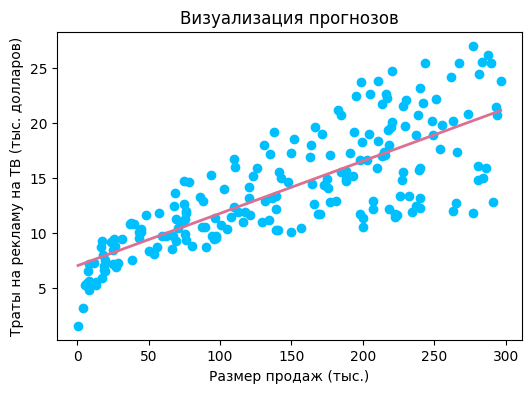

In [17]:
plt.figure(figsize=(6, 4))
plt.title('Визуализация прогнозов')

plt.scatter(data.TV, data.Sales, c='deepskyblue')
plt.plot(X_new, preds, c='palevioletred', linewidth=2)
plt.xlabel('Размер продаж (тыс.)')
plt.ylabel('Траты на рекламу на ТВ (тыс. долларов)')
plt.show()

## Насколько хорошо модель соответствует данным?

После того, как мы построили модель логично задаться вопросом: а насколько хорошей она вышла?

Одним из способом оценки качества линейной модели является значение **R-квадрат**. R-квадрат **это доля объяснённой суммы квадратов в общей**:

$$R^2 = 1 - \frac{\sum_i(y_i - \hat{y}_i)^2}{\sum_i(y_i - \overline{y})^2}$$

Чем выше R-квадрат, тем лучше, потому что это означает, что большая дисперсия объясняется моделью. Вот пример того, как выглядит R-квадрат":

<img src="https://github.com/hse-python-mirec/dap_mirec_2022/blob/main/seminar9/images/08_r_squared.png?raw=true">

Вы можете видеть, что **синяя линия** объясняет некоторую дисперсию в данных (R-квадрат=0,54), **зеленая линия** объясняет большую часть дисперсии (R-квадрат=0,64), а **красная линия** еще больше подходит к данным обучения (R-квадрат=0,66). (Красная линия выглядит так, как будто она **слишком сильно подстраивается**?)

Давайте вычислим значение R-квадрата для нашей простой линейной модели:

In [18]:
r_2 = lm.rsquared
r_2

0.6118750508500712

Является ли это "хорошим" значением R-квадрата? Трудно сказать. Порог для хорошего значения R-квадрата широко зависит от области, от набора данных, который мы рассматриваем и еще много чего. Поэтому он наиболее полезен в качестве инструмента для **сравнения различных моделей**.

Мы уже научились считать R2 score, однако есть еще две важные метрики, которые чаще всего используются - MSE и MAE.

**MSE** еще называется **среднеквадратичная ошибка**. Вычисляет она средний квадрат отклонения ответов модели от истинных.  
$$MSE = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2$$

**MAE** - это **средняя абсолютная ошибка**. И по сути она показывает на сколько в среднем ответ нашей модели отклоняется от верного. В отличие от *MSE* эта метрика лучше интерпретируется (потому что нет квадрата отклонения) и более устойчива к выбросам (по той же причине).
$$MAE = \frac{1}{n} \sum_{i=1}^n |y_i - \hat{y}_i|$$


In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [20]:
lm = smf.ols(formula='Sales ~ TV', data=data).fit()
pred = lm.predict(data['TV'])

mse = mean_squared_error(pred, data['Sales'])

print('MSE = {}'.format(mse))

mae = mean_absolute_error(pred, data['Sales'])

print('MAE = {}'.format(mae))

MSE = 10.512652915656757
MAE = 2.5498060389274864


## Множественная линейная регрессия

Простая линейная регрессия может быть легко расширена для включения нескольких объектов. Это называется **множественной линейной регрессией** (вообще, когда говорят о линейной регрессии подразумевают именно ее):

$y = \beta_0 + \beta_1x_1 + ... + \beta_nx_n$

Каждый $x$ представляет собой отдельный признак и имеет свой собственный коэффициент.

Если вернуться к нашему набору данных, то формула будет выглядеть как-то так:

$Sales = \beta_0 + \beta_1 \times TV + \beta_2 \times Radio + \beta_3 \times Newspaper$

Давайте воспользуемся Statsmodels для оценки этих коэффициентов:

In [21]:
# как и раньше создаём модель по формуле
lm = smf.ols(formula='Sales ~ TV + Radio + Newspaper', data=data).fit()

# и выводим коэффициенты
lm.params

Intercept    2.938889
TV           0.045765
Radio        0.188530
Newspaper   -0.001037
dtype: float64

Теперь наша формула для представления данных изменилась, поэому формула в smf.ols() тоже изменилась на $Sales \sim TV + Radio + Newspaper$, что значит, что мы хотим представить *Sales* в виде суммы (взвешенной) признаков.

Как мы интерпретируем эти коэффициенты? Для данной суммы расходов на рекламу на радио и в газетах **увеличение расходов на рекламу на телевидении на 1000 долларов увеличивает продажы на 45.765**.


## Несколько слов про значимость полученных результатов

Вы должны понимать, что **коэффициенты полученные вами это случайные величины**. В примере выше, например, можно сказать, что **реклама в газетах уменьшает количество проданного товара**, тк коэффициент перед сооствествующим коэффициентом отрицательный. Однако, из-за того, что коэффициент маленький **так могло произойти случайно**. Вы можете посмотреть отчет, который предлагает Statsmodels и сделать "примерные" выводы о значимости каждого коэффициента

In [22]:
# выведем саммари по полученной модели

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Thu, 03 Apr 2025   Prob (F-statistic):           1.58e-96
Time:                        18:51:03   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
Radio          0.1885      0.009     21.893      0.000       0.172       0.206
Newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Что можно увидеть по результатам выше?

- Расходы на рекламу на телевидении и радио **положительно связаны** с продажами, в то время как расходы на рекламу в газетах **незначимо отрицательно связаны** с продажами.
- Эта модель имеет более высокий **R-квадрат** (0.897), чем предыдущая модель, что означает, что эта модель обеспечивает лучшее соответствие данным, чем модель, включающая только TV (что ожидаемо).

In [23]:
lm = smf.ols(formula='Sales ~ TV + Radio + Newspaper', data=data).fit()
pred = lm.predict(data[['TV', 'Radio', 'Newspaper']])

mse = mean_squared_error(pred, data['Sales'])

print('MSE = {}'.format(mse))

mae = mean_absolute_error(pred, data['Sales'])

print('MAE = {}'.format(mae))

r_2 = lm.rsquared
print('R^2 = {}'.format(r_2))

MSE = 2.784126314510936
MAE = 1.252011229687068
R^2 = 0.8972106381789522


In [24]:
lm = smf.ols(formula='Sales ~ TV + Radio', data=data).fit()
pred = lm.predict(data[['TV', 'Radio']])

mse = mean_squared_error(pred, data['Sales'])

print('MSE = {}'.format(mse))

mae = mean_absolute_error(pred, data['Sales'])

print('MAE = {}'.format(mae))

r_2 = lm.rsquared
print('R^2 = {}'.format(r_2))

MSE = 2.784569900338091
MAE = 1.2537471644234026
R^2 = 0.8971942610828957


<div class="alert alert-block alert-success">

https://edu.hse.ru/course/view.php?id=133381
решаем задачи А13

<div class="alert alert-block alert-info" style="margin-top: 20px">
    
## А13 Вопрос 1
    
Метеоролог Александр хочет оценить зависимость количества осадков (в мм) perc
от температуры воздуха (в градусах Цельсия) $temp$
и скорости ветра (в м/с) $speed$
при помощи линейной модели. Жизненный опыт подсказывает Александру, что в модель будет линейной, и именно в такой спецификации он и проводит оценку модели. Оценённое уравнение регрессии выглядит следующим образом:

$$ \hat{perc}i=4+0.1×temp_i−0.12×speed_i.$$

Выберите верное утверждение об интерпретации оценённой модели.


    Выберите один ответ:
    

При увеличении температуры воздуха на 1 количество осадков увеличивается примерно на 0.1 мм. 

    

При увеличении скорости ветра на 1 м/с количество осадков увеличивается примерно на 0.12 мм.

    

При увеличении температуры воздуха на 1 градус Цельсия количество осадков уменьшится примерно на 0.1 мм. 


    
При увеличении температуры воздуха на 1 градус Цельсия скорость ветра уменьшается примерно на 0.12 м/с.

<div class="alert alert-block alert-info" style="margin-top: 20px">
    
## А13 Вопрос 2
    
Метеоролог Степан хочет оценить зависимость количества осадков (в мм) perc
  от температуры воздуха (в градусах Цельсия) temp
 и скорости ветра (в м/с) speed
 при помощи линейной модели. Жизненный опыт подсказывает Александру, что в модель стоит включить абсолютное значение скорости ветра, и именно в такой спецификации он и проводит оценку модели. Оценённое уравнение регрессии выглядит следующим образом:

$$ \hat{perc}_i=10+2×temp_i+28.5×speed_i $$

где perci
 – значение целевой переменной для наблюдения i
, $temp_i$
 и $speed_i$
 – значения признаков для наблюдения i
.

Выберите верное утверждение об интерпретации оценённой модели.


    Выберите один ответ:

При любых значениях признаков количество осадков больше 10. 

При увеличении скорости ветра количество осадков уменьшается. 


При увеличении температуры воздуха на 2 градуса Цельсия количество осадков увеличится на 4 мм. 


При увеличении скорости ветра на 1%, то количество осадков увеличится на 28.5 мм.

<div class="alert alert-block alert-info" style="margin-top: 20px">
    
## А13 Вопрос 3
    
Скидка, которую получает пользователь интернет-магазина, определяется по следующей формуле:

Скидка (в процентах) = 5 + 10*Р + ln(Т),

где Р — зарегистрирован ли пользователь (1 — зарегистрирован, 0 — не зарегистрирован),

Т — количество товаров в заказе (не менее 5 и не более 100).




    Выберите все верные утверждения:


    

На один и тот же заказ зарегистрированный пользователь получит большую скидку, чем незарегистрированный


На любой заказ незарегистрированного пользователя скидка будет больше, чем на любой заказ зарегистрированного


Максимальная скидка, которую может получить пользователь - 15%


Минимальная скидка, которую может получить пользователь - 5%

<div class="alert alert-block alert-info" style="margin-top: 20px">
    
## А13 Вопрос 4
    
Рейтинг ресторана в каталоге определяется по следующей формуле:

Рейтинг (в звездах) =  ln N + M, где

N - общее количество отзывов,

M - средняя оценка, поставленная пользователем в отзыве (от 1 до 5).




    Выберите верные утверждения (от 1 до 4):

Ответ

При увеличении средней оценки в 2 раза рейтинг увеличится на 2 звезды


При увеличении количества отзывов в 10 раз рейтинг увеличится более чем на 2 звезды


При увеличении средней оценки в 2 раза рейтинг увеличится более чем на 10 звезд


При увеличении количества отзывов в 2 раза рейтинг увеличится более чем на 10 звезд

<div class="alert alert-block alert-success">

https://edu.hse.ru/course/view.php?id=133381
решаем задачи А14

<div class="alert alert-block alert-info" style="margin-top: 20px">
    
## А14 Вопрос 1
    
Выберите верное утверждение о метриках качества, применяемых к модели линейной регрессии с константным признаком, обучаемой при помощи минимизации MSE.

Расшифровка:

MSE (mean squared error) – среднеквадратичная ошибка.

MAE (mean absolute error) – средняя абсолютная ошибка. 


    Выберите один ответ:

Для такой модели MSE всегда будет меньше MAE.


MSE и MAE для такой модели не могут совпадать. 


R2
 не является адекватным показателем качества для этой модели.


Максимизация R2
 в этой модели эквивалентна минимизации MSE.

<div class="alert alert-block alert-info" style="margin-top: 20px">
    
## А14 Вопрос 2
    
Выберите верное утверждение о метриках качества, применяемых к модели линейной регрессии c константным признаком, обучаемой при помощи минимизации MSE (среднеквадратичной ошибки).


    Выберите один ответ:

Для сравнения таких моделей можно использовать лишь MSE. 

Для сравнения таких моделей можно использовать MAE (среднюю абсолютную ошибку). 


Максимизация R2
 для такой модели никак не связана с минимизацией MSE. 


R2
 в такой модели всегда больше 0.8. 

<div class="alert alert-block alert-info" style="margin-top: 20px">
    
## А14 Вопрос 3
Выберите метрики качества, которые подходят для сравнения двух линейных моделей, построенных для предсказания возраста дерева на основе его высоты и диаметра:


    Ответ

MAE


MSE


ROC-кривая


R2

<div class="alert alert-block alert-info" style="margin-top: 20px">
    
## А14 Вопрос 4
Строится модель линейной регрессии. Известно, что в выборке, на которой будет обучаться модель, присутствуют выбросы. 

Какая метрика лучше всего подойдет для оценки качества этой модели?


    Ответ

Среднее значение квадрата модуля разности между реальными и предсказанными значениями


Среднее значение разности между реальными и предсказанными значениями


Среднее значение модуля разности между реальными и предсказанными значениями


Среднее значение квадрата разности между реальными и предсказанными значениями